In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
from tqdm import tqdm
import contractions
import nltk
import string


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
#from symspellpy import SymSpell, Verbosity
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Reading VAERS data file 

In [2]:
vaersdata = pd.read_csv('../Datasets/2023VAERSData/2023VAERSDATA.csv', encoding= 'unicode_escape')
vaersdata_SYMPTOMS = pd.read_csv('../Datasets/2023VAERSData/2023VAERSSYMPTOMS.csv')
vaersdata_VAX = pd.read_csv('../Datasets/2023VAERSData/2023VAERSVAX.csv')

/var/folders/_l/b6xwsf494bjcy6h68bqlx5jh0000gn/T/ipykernel_1634/3593954213.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  vaersdata = pd.read_csv('../Datasets/2023VAERSData/2023VAERSDATA.csv', encoding= 'unicode_escape')


In [3]:
vaersdata.shape

(19992, 35)

### Choosign columns of interest in order to combine them to a single text column. The columns of interest are Symptom Text, Lab Data, Cur Ill, History. These are combined together to create a column called feature text 

In [4]:
# SYMPTOM_TEXT,LAB_DATA, CUR_ILL, HISTORY - take
# anything more ? OTHER_MEDS, PRIOR_VAX, ALLERGIES 
#other med mostly contains the medication names from 

def collect_text(x):
    feature_string = ['']
    
    if not pd.isnull(x['SYMPTOM_TEXT']):
        feature_string += [x['SYMPTOM_TEXT']]
    
    if not pd.isnull(x['LAB_DATA']):
        feature_string += [x['LAB_DATA']]
    
    if not pd.isnull(x['CUR_ILL']):
        feature_string += [x['CUR_ILL']]
        
    if not pd.isnull(x['HISTORY']):
        feature_string += [x['HISTORY']]
        
    return ' '.join(feature_string)

vaersdata['feature_text'] = vaersdata.apply(lambda x: collect_text(x), axis=1)

## Taking ground truth annoations from the Symptoms File

In [5]:
def collect_ground_truth(x):
    ground_truth_string = []
    gt_string = x['SYMPTOM1'].tolist() + x['SYMPTOM2'].tolist() + x['SYMPTOM3'].tolist() + x['SYMPTOM4'].tolist() + x['SYMPTOM5'].tolist()
        
    for gt in gt_string:
        if not pd.isnull(gt):
            ground_truth_string.append(gt)    
    return '. '.join(ground_truth_string)

vaersdata['ground_truth_annotation'] = vaersdata_SYMPTOMS.groupby('VAERS_ID').apply(lambda x: collect_ground_truth(x))

## Pre-processing the text column to clean it 

In [6]:
vaersdata["pn_history_lower"] = vaersdata["feature_text"].str.lower()
regex = re.compile(r'<[^>]+>')
vaersdata["pn_history_noContractions"] = vaersdata["pn_history_lower"].apply(contractions.fix)

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
vaersdata["pn_history_noUnicode"] = vaersdata["pn_history_noContractions"].apply(remove_unicode_chars)

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text
vaersdata["pn_history_noPuncts"] = vaersdata["pn_history_noUnicode"].apply(remove_punctuations)

def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
vaersdata["pn_history_noES"] = vaersdata["pn_history_noPuncts"].apply(remove_extra_spaces)
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
vaersdata["pn_history_preprocessed"] = vaersdata["pn_history_noES"].apply(lemmatize_text)

### Selecting 10,000 records to run the developed algorithm on this dataset

In [8]:
vaersdata_sample = vaersdata[:10000]

## KeyBERT models with custom embedding models selected after analysing the EvaluationOfModels.ipynb file

In [11]:
from keybert import KeyBERT
distilroberta = KeyBERT(model="all-distilroberta-v1")
bioclinical_bert = KeyBERT(model="emilyalsentzer/Bio_ClinicalBERT")
biomedNLP = KeyBERT(model="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

No sentence-transformers model found with name /Users/aishwariyagupta/.cache/torch/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/aishwariyagupta/.cache/torch/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (ini

In [12]:
from datetime import datetime

### Implementing the Vectorisation process in order to optimze the process of extracting keywords

## 2 Keywords

In [32]:
def vec_impl(model, df):
    return model.extract_keywords(
                df['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 2),
                use_mmr=True, 
                diversity=0.7)

In [33]:
st=datetime.now()
l_distilroberta= []
l_distilroberta.append(vec_impl(distilroberta, vaersdata_sample))
et=datetime.now()
(et-st).seconds

981

In [13]:
st=datetime.now()
l_bioclinical_bert= []
l_bioclinical_bert.append(vec_impl(bioclinical_bert, vaersdata_sample))
et=datetime.now()
(et-st).seconds

2054

In [14]:
st=datetime.now()
l_biomedNLP= []
l_biomedNLP.append(vec_impl(biomedNLP, vaersdata_sample))
et=datetime.now()
(et-st).seconds

1802

In [15]:
vaersdata_sample = vaersdata_sample.reset_index(drop=True)

In [13]:
def first_keyword(x):
    try:
        return x[0][0], x[0][1]
    except:
        return np.nan, np.nan

def second_keyword(x):
    try:
        return x[1][0], x[1][1]
    except:
        return np.nan, np.nan

def third_keyword(x):
    try:
        return x[2][0], x[2][1]
    except:
        return np.nan, np.nan

In [17]:
l_distilroberta = pd.DataFrame(l_distilroberta).T
l_distilroberta = l_distilroberta.rename(columns={0:'keywords'})
l_distilroberta.keywords = l_distilroberta.keywords.apply(lambda x: eval(str(x)))

l_distilroberta['first_keyword'], l_distilroberta['first_keyword_score'] = zip(*l_distilroberta['keywords'].apply(lambda x: first_keyword(x)))

l_distilroberta['second_keyword'], l_distilroberta['second_keyword_score'] = zip(*l_distilroberta['keywords'].apply(lambda x: second_keyword(x)))

l_distilroberta['third_keyword'], l_distilroberta['third_keyword_score'] = zip(*l_distilroberta['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_distillroberta = vaersdata_sample.join(pd.DataFrame(l_distilroberta, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [18]:
l_bioclinical_bert = pd.DataFrame(l_bioclinical_bert).T
l_bioclinical_bert = l_bioclinical_bert.rename(columns={0:'keywords'})
l_bioclinical_bert.keywords = l_bioclinical_bert.keywords.apply(lambda x: eval(str(x)))

l_bioclinical_bert['first_keyword'], l_bioclinical_bert['first_keyword_score'] = zip(*l_bioclinical_bert['keywords'].apply(lambda x: first_keyword(x)))

l_bioclinical_bert['second_keyword'], l_bioclinical_bert['second_keyword_score'] = zip(*l_bioclinical_bert['keywords'].apply(lambda x: second_keyword(x)))

l_bioclinical_bert['third_keyword'], l_bioclinical_bert['third_keyword_score'] = zip(*l_bioclinical_bert['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_bioclinical_bert = vaersdata_sample.join(pd.DataFrame(l_bioclinical_bert, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [19]:
l_biomedNLP = pd.DataFrame(l_biomedNLP).T
l_biomedNLP = l_biomedNLP.rename(columns={0:'keywords'})
l_biomedNLP.keywords = l_biomedNLP.keywords.apply(lambda x: eval(str(x)))

l_biomedNLP['first_keyword'], l_biomedNLP['first_keyword_score'] = zip(*l_biomedNLP['keywords'].apply(lambda x: first_keyword(x)))

l_biomedNLP['second_keyword'], l_biomedNLP['second_keyword_score'] = zip(*l_biomedNLP['keywords'].apply(lambda x: second_keyword(x)))

l_biomedNLP['third_keyword'], l_biomedNLP['third_keyword_score'] = zip(*l_biomedNLP['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_biomedNLP = vaersdata_sample.join(pd.DataFrame(l_biomedNLP, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [20]:
vaersdata_bioclinical_bert.to_csv("10kbioclinical_test_two_keywords_extraction_with_score.csv")
vaersdata_biomedNLP.to_csv("10kbiomedNLP_test_two_keywords_extraction_with_score.csv")
vaersdata_distillroberta.to_csv("10kdistillroberta_test_two_keywords_extraction_with_score.csv")

## 3 Keywords

In [21]:
def vec_impl_3kw(model, df):
    return model.extract_keywords(
                df['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 3),
                use_mmr=True, 
                diversity=0.7)

In [22]:
st=datetime.now()
l_distilroberta_3kw= []
l_distilroberta_3kw.append(vec_impl_3kw(distilroberta, vaersdata_sample))
et=datetime.now()
(et-st).seconds

1828

In [23]:
st=datetime.now()
l_bioclinical_bert_3kw= []
l_bioclinical_bert_3kw.append(vec_impl_3kw(bioclinical_bert, vaersdata_sample))
et=datetime.now()
(et-st).seconds

3914

In [26]:
st=datetime.now()
l_biomedNLP_3kw= []
l_biomedNLP_3kw.append(vec_impl_3kw(biomedNLP, vaersdata_sample))
et=datetime.now()
(et-st).seconds

3403

In [27]:
l_biomedNLP_3kw = pd.DataFrame(l_biomedNLP_3kw).T
l_biomedNLP_3kw = l_biomedNLP_3kw.rename(columns={0:'keywords'})
l_biomedNLP_3kw.keywords = l_biomedNLP_3kw.keywords.apply(lambda x: eval(str(x)))

l_biomedNLP_3kw['first_keyword'], l_biomedNLP_3kw['first_keyword_score'] = zip(*l_biomedNLP_3kw['keywords'].apply(lambda x: first_keyword(x)))

l_biomedNLP_3kw['second_keyword'], l_biomedNLP_3kw['second_keyword_score'] = zip(*l_biomedNLP_3kw['keywords'].apply(lambda x: second_keyword(x)))

l_biomedNLP_3kw['third_keyword'], l_biomedNLP_3kw['third_keyword_score'] = zip(*l_biomedNLP_3kw['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_distillroberta_3kw = vaersdata_sample.join(pd.DataFrame(l_biomedNLP_3kw, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))

In [28]:
l_bioclinical_bert_3kw = pd.DataFrame(l_bioclinical_bert_3kw).T
l_bioclinical_bert_3kw = l_bioclinical_bert_3kw.rename(columns={0:'keywords'})
l_bioclinical_bert_3kw.keywords = l_bioclinical_bert_3kw.keywords.apply(lambda x: eval(str(x)))

l_bioclinical_bert_3kw['first_keyword'], l_bioclinical_bert_3kw['first_keyword_score'] = zip(*l_bioclinical_bert_3kw['keywords'].apply(lambda x: first_keyword(x)))

l_bioclinical_bert_3kw['second_keyword'], l_bioclinical_bert_3kw['second_keyword_score'] = zip(*l_bioclinical_bert_3kw['keywords'].apply(lambda x: second_keyword(x)))

l_bioclinical_bert_3kw['third_keyword'], l_bioclinical_bert_3kw['third_keyword_score'] = zip(*l_bioclinical_bert_3kw['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_bioclinical_bert_3kw = vaersdata_sample.join(pd.DataFrame(l_bioclinical_bert_3kw, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [29]:
l_distilroberta_3kw = pd.DataFrame(l_distilroberta_3kw).T
l_distilroberta_3kw = l_distilroberta_3kw.rename(columns={0:'keywords'})
l_distilroberta_3kw.keywords = l_distilroberta_3kw.keywords.apply(lambda x: eval(str(x)))

l_distilroberta_3kw['first_keyword'], l_distilroberta_3kw['first_keyword_score'] = zip(*l_distilroberta_3kw['keywords'].apply(lambda x: first_keyword(x)))

l_distilroberta_3kw['second_keyword'], l_distilroberta_3kw['second_keyword_score'] = zip(*l_distilroberta_3kw['keywords'].apply(lambda x: second_keyword(x)))

l_distilroberta_3kw['third_keyword'], l_distilroberta_3kw['third_keyword_score'] = zip(*l_distilroberta_3kw['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_biomedNLP_3kw = vaersdata_sample.join(pd.DataFrame(l_distilroberta_3kw, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [30]:
vaersdata_distillroberta_3kw.to_csv("10kdistillroberta_test_three_keywords_extraction_with_score.csv")
vaersdata_bioclinical_bert_3kw.to_csv("10kbioclinical_test_three_keywords_extraction_with_score.csv")
vaersdata_biomedNLP_3kw.to_csv("10kbiomedNLP_test_three_keywords_extraction_with_score.csv")

## 4 Keywords

In [15]:
def vec_impl_4kw(model, df):
    return model.extract_keywords(
                df['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 4),
                use_mmr=True, 
                diversity=0.7)

In [32]:
st=datetime.now()
l_distilroberta_4kw= []
l_distilroberta_4kw.append(vec_impl_4kw(distilroberta, vaersdata_sample))
et=datetime.now()
(et-st).seconds

3166

In [35]:
st=datetime.now()
l_bioclinical_bert_4kw= []
l_bioclinical_bert_4kw.append(vec_impl_4kw(bioclinical_bert, vaersdata_sample))
et=datetime.now()
(et-st).seconds

4827

In [36]:
st=datetime.now()
l_biomedNLP_4kw= []
l_biomedNLP_4kw.append(vec_impl_4kw(biomedNLP, vaersdata_sample))
et=datetime.now()
(et-st).seconds

4341

In [41]:
l_bioclinical_bert_4kw_df= pd.DataFrame(l_bioclinical_bert_4kw)
l_bioclinical_bert_4kw_df=pd.DataFrame(l_bioclinical_bert_4kw_df).T
l_bioclinical_bert_4kw_df = l_bioclinical_bert_4kw_df.rename(columns={0:'keywords'})
l_bioclinical_bert_4kw_df.keywords = l_bioclinical_bert_4kw_df.keywords.apply(lambda x: eval(str(x)))
l_bioclinical_bert_4kw_df['first_keyword'], l_bioclinical_bert_4kw_df['first_keyword_score'] = zip(*l_bioclinical_bert_4kw_df['keywords'].apply(lambda x: first_keyword(x)))
l_bioclinical_bert_4kw_df['second_keyword'], l_bioclinical_bert_4kw_df['second_keyword_score'] = zip(*l_bioclinical_bert_4kw_df['keywords'].apply(lambda x: second_keyword(x)))
l_bioclinical_bert_4kw_df['third_keyword'], l_bioclinical_bert_4kw_df['third_keyword_score'] = zip(*l_bioclinical_bert_4kw_df['keywords'].apply(lambda x: third_keyword(x)))
vaersdata_bioclinical_bert_4kw = vaersdata_sample.join(pd.DataFrame(l_bioclinical_bert_4kw_df, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [64]:
l_biomedNLP_4kw = pd.DataFrame(l_biomedNLP_4kw).T
l_biomedNLP_4kw = l_biomedNLP_4kw.rename(columns={0:'keywords'})
l_biomedNLP_4kw.keywords = l_biomedNLP_4kw.keywords.apply(lambda x: eval(str(x)))

l_biomedNLP_4kw['first_keyword'], l_biomedNLP_4kw['first_keyword_score'] = zip(*l_biomedNLP_4kw['keywords'].apply(lambda x: first_keyword(x)))

l_biomedNLP_4kw['second_keyword'], l_biomedNLP_4kw['second_keyword_score'] = zip(*l_biomedNLP_4kw['keywords'].apply(lambda x: second_keyword(x)))

l_biomedNLP_4kw['third_keyword'], l_biomedNLP_4kw['third_keyword_score'] = zip(*l_biomedNLP_4kw['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_biomedNLP_4kw = vaersdata_sample.join(pd.DataFrame(l_biomedNLP_4kw, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))

In [37]:
l_distilroberta_4kw = pd.DataFrame(l_distilroberta_4kw).T
l_distilroberta_4kw = l_distilroberta_3kw.rename(columns={0:'keywords'})
l_distilroberta_4kw.keywords = l_distilroberta_4kw.keywords.apply(lambda x: eval(str(x)))

l_distilroberta_4kw['first_keyword'], l_distilroberta_4kw['first_keyword_score'] = zip(*l_distilroberta_4kw['keywords'].apply(lambda x: first_keyword(x)))

l_distilroberta_4kw['second_keyword'], l_distilroberta_4kw['second_keyword_score'] = zip(*l_distilroberta_4kw['keywords'].apply(lambda x: second_keyword(x)))

l_distilroberta_4kw['third_keyword'], l_distilroberta_4kw['third_keyword_score'] = zip(*l_distilroberta_4kw['keywords'].apply(lambda x: third_keyword(x)))

vaersdata_distillroberta_4kw = vaersdata_sample.join(pd.DataFrame(l_distilroberta_4kw, columns=['first_keyword','first_keyword_score' 
                                                                                        ,'second_keyword','second_keyword_score',
                                                                                        'third_keyword','third_keyword_score']))


In [ ]:
vaersdata_distillroberta_4kw.to_csv("10kdistillroberta_test_four_keywords_extraction_with_score.csv")
vaersdata_bioclinical_bert_4kw.to_csv("10kbioclinical_test_four_keywords_extraction_with_score.csv")
vaersdata_biomedNLP_4kw.to_csv("10kbiomedNLP_test_four_keywords_extraction_with_score.csv")

### Reading files and joining them 

In [66]:
vaersdata_distillroberta_2kw = pd.read_csv("10kdistillroberta_test_two_keywords_extraction_with_score.csv")
vaersdata_distillroberta_3kw = pd.read_csv("10kdistillroberta_test_three_keywords_extraction_with_score.csv")
vaersdata_distillroberta_4kw = pd.read_csv("10kdistillroberta_test_four_keywords_extraction_with_score.csv")

In [67]:
vaersdata_distillroberta_2kw3kw= vaersdata_distillroberta_2kw.join(vaersdata_distillroberta_3kw[['first_keyword','first_keyword_score',
                                                                       'second_keyword','second_keyword_score',
                                                                       'third_keyword','third_keyword_score']],lsuffix="_2kw",rsuffix="_3kw")

In [68]:
vaersdata_distillroberta=vaersdata_distillroberta_2kw3kw.join(vaersdata_distillroberta_4kw[['first_keyword','first_keyword_score',
                                                                       'second_keyword','second_keyword_score',
                                                                       'third_keyword','third_keyword_score']],rsuffix="_3kw")

In [69]:
vaersdata_distillroberta=vaersdata_distillroberta.rename(columns={"first_keyword": "first_keyword_4kw", "first_keyword_score": "first_keyword_score_4kw",
                                        "second_keyword":"second_keyword_4kw","second_keyword_score":"second_keyword_score_4kw",
                                       "third_keyword":"third_keyword_4kw","third_keyword_score":"third_keyword_score_4kw" })

In [70]:
vaersdata_bioclinical_bert_2kw = pd.read_csv("10kbioclinical_test_two_keywords_extraction_with_score.csv")
vaersdata_bioclinical_bert_3kw = pd.read_csv("10kbioclinical_test_three_keywords_extraction_with_score.csv")
vaersdata_bioclinical_bert_4kw = pd.read_csv("10kbioclinical_test_four_keywords_extraction_with_score.csv")

In [71]:
vaersdata_biomedNLP_2kw = pd.read_csv("10kbiomedNLP_test_two_keywords_extraction_with_score.csv")
vaersdata_biomedNLP_3kw = pd.read_csv("10kbiomedNLP_test_three_keywords_extraction_with_score.csv")
vaersdata_biomedNLP_4kw = pd.read_csv("10kbiomedNLP_test_four_keywords_extraction_with_score.csv")

In [72]:
vaersdata_bioclinical_bert_2kw3kw= vaersdata_bioclinical_bert_2kw.join(vaersdata_bioclinical_bert_3kw[['first_keyword','first_keyword_score',
                                                                       'second_keyword','second_keyword_score',
                                                                       'third_keyword','third_keyword_score']],lsuffix="_2kw",rsuffix="_3kw")

vaersdata_bioclinical_bert=vaersdata_bioclinical_bert_2kw3kw.join(vaersdata_bioclinical_bert_4kw[['first_keyword','first_keyword_score',
                                                                       'second_keyword','second_keyword_score',
                                                                       'third_keyword','third_keyword_score']],rsuffix="_3kw")
vaersdata_bioclinical_bert=vaersdata_bioclinical_bert.rename(columns={"first_keyword": "first_keyword_4kw", "first_keyword_score": "first_keyword_score_4kw",
                                        "second_keyword":"second_keyword_4kw","second_keyword_score":"second_keyword_score_4kw",
                                       "third_keyword":"third_keyword_4kw","third_keyword_score":"third_keyword_score_4kw" })

In [73]:
vaersdata_biomedNLP_2kw3kw= vaersdata_biomedNLP_2kw.join(vaersdata_biomedNLP_3kw[['first_keyword','first_keyword_score',
                                                                       'second_keyword','second_keyword_score',
                                                                       'third_keyword','third_keyword_score']],lsuffix="_2kw",rsuffix="_3kw")

vaersdata_biomedNLP=vaersdata_biomedNLP_2kw3kw.join(vaersdata_biomedNLP_4kw[['first_keyword','first_keyword_score',
                                                                       'second_keyword','second_keyword_score',
                                                                       'third_keyword','third_keyword_score']],rsuffix="_3kw")
vaersdata_biomedNLP=vaersdata_biomedNLP.rename(columns={"first_keyword": "first_keyword_4kw", "first_keyword_score": "first_keyword_score_4kw",
                                        "second_keyword":"second_keyword_4kw","second_keyword_score":"second_keyword_score_4kw",
                                       "third_keyword":"third_keyword_4kw","third_keyword_score":"third_keyword_score_4kw" })

### Final files with all keywords extracted. The next cell will filter out the keywords and remove the ones which are less than 0.25 cosine similarity score

In [35]:
#vaersdata_bioclinical_bert
#vaersdata_biomedNLP
#vaersdata_distillroberta

In [74]:
vaersdata_bioclinical_bert.first_keyword_2kw= np.where(vaersdata_bioclinical_bert.first_keyword_score_2kw > 0.25, vaersdata_bioclinical_bert.first_keyword_2kw, np.nan)
vaersdata_bioclinical_bert.second_keyword_2kw = np.where(vaersdata_bioclinical_bert.second_keyword_score_2kw > 0.25, vaersdata_bioclinical_bert.second_keyword_2kw, np.nan)
vaersdata_bioclinical_bert.third_keyword_2kw = np.where(vaersdata_bioclinical_bert.third_keyword_score_2kw > 0.25, vaersdata_bioclinical_bert.third_keyword_2kw, np.nan)

In [75]:
vaersdata_bioclinical_bert.first_keyword_3kw= np.where(vaersdata_bioclinical_bert.first_keyword_score_3kw > 0.25, vaersdata_bioclinical_bert.first_keyword_3kw, np.nan)
vaersdata_bioclinical_bert.second_keyword_3kw = np.where(vaersdata_bioclinical_bert.second_keyword_score_3kw > 0.25, vaersdata_bioclinical_bert.second_keyword_3kw, np.nan)
vaersdata_bioclinical_bert.third_keyword_3kw = np.where(vaersdata_bioclinical_bert.third_keyword_score_3kw > 0.25, vaersdata_bioclinical_bert.third_keyword_3kw, np.nan)

In [76]:
vaersdata_bioclinical_bert.first_keyword_4kw= np.where(vaersdata_bioclinical_bert.first_keyword_score_4kw > 0.25, vaersdata_bioclinical_bert.first_keyword_4kw, np.nan)
vaersdata_bioclinical_bert.second_keyword_4kw = np.where(vaersdata_bioclinical_bert.second_keyword_score_4kw > 0.25, vaersdata_bioclinical_bert.second_keyword_4kw, np.nan)
vaersdata_bioclinical_bert.third_keyword_4kw = np.where(vaersdata_bioclinical_bert.third_keyword_score_4kw > 0.25, vaersdata_bioclinical_bert.third_keyword_4kw, np.nan)

In [77]:
vaersdata_biomedNLP.first_keyword_2kw= np.where(vaersdata_biomedNLP.first_keyword_score_2kw > 0.25, vaersdata_biomedNLP.first_keyword_2kw, np.nan)
vaersdata_biomedNLP.second_keyword_2kw = np.where(vaersdata_biomedNLP.second_keyword_score_2kw > 0.25, vaersdata_biomedNLP.second_keyword_2kw, np.nan)
vaersdata_biomedNLP.third_keyword_2kw = np.where(vaersdata_biomedNLP.third_keyword_score_2kw > 0.25, vaersdata_biomedNLP.third_keyword_2kw, np.nan)

In [78]:
vaersdata_biomedNLP.first_keyword_3kw= np.where(vaersdata_biomedNLP.first_keyword_score_3kw > 0.25, vaersdata_biomedNLP.first_keyword_3kw, np.nan)
vaersdata_biomedNLP.second_keyword_3kw = np.where(vaersdata_biomedNLP.second_keyword_score_3kw > 0.25, vaersdata_biomedNLP.second_keyword_3kw, np.nan)
vaersdata_biomedNLP.third_keyword_3kw = np.where(vaersdata_biomedNLP.third_keyword_score_3kw > 0.25, vaersdata_biomedNLP.third_keyword_3kw, np.nan)

In [79]:
vaersdata_biomedNLP.first_keyword_4kw= np.where(vaersdata_biomedNLP.first_keyword_score_4kw > 0.25, vaersdata_biomedNLP.first_keyword_4kw, np.nan)
vaersdata_biomedNLP.second_keyword_4kw = np.where(vaersdata_biomedNLP.second_keyword_score_4kw > 0.25, vaersdata_biomedNLP.second_keyword_4kw, np.nan)
vaersdata_biomedNLP.third_keyword_4kw = np.where(vaersdata_biomedNLP.third_keyword_score_4kw > 0.25, vaersdata_biomedNLP.third_keyword_4kw, np.nan)

In [80]:
vaersdata_distillroberta.first_keyword_2kw= np.where(vaersdata_distillroberta.first_keyword_score_2kw > 0.25, vaersdata_distillroberta.first_keyword_2kw, np.nan)
vaersdata_distillroberta.second_keyword_2kw = np.where(vaersdata_distillroberta.second_keyword_score_2kw > 0.25, vaersdata_distillroberta.second_keyword_2kw, np.nan)
vaersdata_distillroberta.third_keyword_2kw = np.where(vaersdata_distillroberta.third_keyword_score_2kw > 0.25, vaersdata_distillroberta.third_keyword_2kw, np.nan)

vaersdata_distillroberta.first_keyword_3kw= np.where(vaersdata_distillroberta.first_keyword_score_3kw > 0.25, vaersdata_distillroberta.first_keyword_3kw, np.nan)
vaersdata_distillroberta.second_keyword_3kw = np.where(vaersdata_distillroberta.second_keyword_score_3kw > 0.25, vaersdata_distillroberta.second_keyword_3kw, np.nan)
vaersdata_distillroberta.third_keyword_3kw = np.where(vaersdata_distillroberta.third_keyword_score_3kw > 0.25, vaersdata_distillroberta.third_keyword_3kw, np.nan)

vaersdata_distillroberta.first_keyword_4kw= np.where(vaersdata_distillroberta.first_keyword_score_4kw > 0.25, vaersdata_distillroberta.first_keyword_4kw, np.nan)
vaersdata_distillroberta.second_keyword_4kw = np.where(vaersdata_distillroberta.second_keyword_score_4kw > 0.25, vaersdata_distillroberta.second_keyword_4kw, np.nan)
vaersdata_distillroberta.third_keyword_4kw = np.where(vaersdata_distillroberta.third_keyword_score_4kw > 0.25, vaersdata_distillroberta.third_keyword_4kw, np.nan)

In [81]:
distillroberta_train_with_scores = vaersdata_distillroberta.iloc[:,44:]

In [82]:
distillroerta_kw_scores = vaersdata_distillroberta[['VAERS_ID', 'pn_history_preprocessed']].join(distillroberta_train_with_scores)

In [83]:
bioclinical_bert_train_with_scores = vaersdata_bioclinical_bert.iloc[:,44:]

In [84]:
bioclinical_kw_scores = vaersdata_bioclinical_bert[['VAERS_ID', 'pn_history_preprocessed']].join(bioclinical_bert_train_with_scores)

In [85]:
biomedNLP_train_with_scores = vaersdata_biomedNLP.iloc[:,44:]
biomedNLP_kw_scores = vaersdata_biomedNLP[['VAERS_ID', 'pn_history_preprocessed']].join(biomedNLP_train_with_scores)

In [86]:
bioclinical_kw_scores.head()

,VAERS_ID,pn_history_preprocessed,first_keyword_2kw,first_keyword_score_2kw,second_keyword_2kw,second_keyword_score_2kw,third_keyword_2kw,third_keyword_score_2kw,first_keyword_3kw,first_keyword_score_3kw,second_keyword_3kw,second_keyword_score_3kw,third_keyword_3kw,third_keyword_score_3kw,first_keyword_4kw,first_keyword_score_4kw,second_keyword_4kw,second_keyword_score_4kw,third_keyword_4kw,third_keyword_score_4kw
0,2547730,the adverse event is that the patient went int...,severe orthostatic,0.8273,patient,0.5731,19,0.5176,caused severe orthostatic,0.8473,patient,0.5731,19,0.5176,resulted zero antibody hospilization,0.8673,headache,0.6047,19,0.5176
1,2547731,error incorrect reconstitution,incorrect reconstitution,0.9308,error,0.7669,incorrect,0.7356,error incorrect reconstitution,1.0000,reconstitution,0.8518,incorrect,0.7356,error incorrect reconstitution,1.0000,reconstitution,0.8518,incorrect,0.7356
2,2547732,error patient accidentally stuck by needle,stuck needle,0.8556,patient accidentally,0.8255,error patient,0.7835,accidentally stuck needle,0.9159,error patient accidentally,0.9027,patient,0.6330,error patient accidentally stuck,0.9645,error,0.6958,stuck,0.6176
3,2547733,error dose in series given too early,error dose,0.8420,given early,0.8024,series,0.6942,dose series given,0.9086,early,0.6972,error,0.6472,error dose series given,0.9382,early,0.6972,error,0.6472
4,2547734,systemic eye twitching medium,eye twitching,0.9441,systemic eye,0.7926,systemic,0.7005,eye twitching medium,0.9768,systemic eye,0.7926,systemic,0.7005,systemic eye twitching medium,1.0000,eye,0.7696,medium,0.7000


In [87]:
bioclinical_kw_scores.to_csv("10Kbioclinical_kw_scores.csv")

## predicting annotations

In [88]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword_2kw, x.second_keyword_2kw, x.third_keyword_2kw, 
                       x.first_keyword_3kw, x.second_keyword_3kw, x.third_keyword_3kw,
                       x.first_keyword_4kw, x.second_keyword_4kw, x.third_keyword_4kw]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
bioclinical_kw_scores['predicted_annotation'] = bioclinical_kw_scores.apply(lambda x: func(x), axis=1)

In [89]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword_2kw, x.second_keyword_2kw, x.third_keyword_2kw, 
                       x.first_keyword_3kw, x.second_keyword_3kw, x.third_keyword_3kw,
                       x.first_keyword_4kw, x.second_keyword_4kw, x.third_keyword_4kw]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
biomedNLP_kw_scores['predicted_annotation'] = biomedNLP_kw_scores.apply(lambda x: func(x), axis=1)

In [90]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword_2kw, x.second_keyword_2kw, x.third_keyword_2kw, 
                       x.first_keyword_3kw, x.second_keyword_3kw, x.third_keyword_3kw,
                       x.first_keyword_4kw, x.second_keyword_4kw, x.third_keyword_4kw]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
distillroerta_kw_scores['predicted_annotation'] = distillroerta_kw_scores.apply(lambda x: func(x), axis=1)

In [91]:
#saving final annotations file
bioclinical_kw_scores.to_csv("10kfinal_annotations_bioclinical.csv")
biomedNLP_kw_scores.to_csv("10kfinal_annotations_biomedNLP.csv")
distillroerta_kw_scores.to_csv("10kfinal_annotations_distillroberta.csv")

## Evaluation Phase 1 : Using Fuzzy Wuzzy Techniques

In [9]:
from thefuzz import fuzz
from thefuzz import process

/Users/aishwariyagupta/Desktop/personal/personal_venv/lib/python3.10/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [93]:
test_vaersdata = pd.read_csv('../Datasets/2023VAERSData/2023VAERSDATA.csv', encoding= 'unicode_escape')

/var/folders/_l/b6xwsf494bjcy6h68bqlx5jh0000gn/T/ipykernel_2917/2572620007.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  test_vaersdata = pd.read_csv('../Datasets/2023VAERSData/2023VAERSDATA.csv', encoding= 'unicode_escape')


In [94]:
bioclincialtest_vaersdata = test_vaersdata.merge(bioclinical_kw_scores[['VAERS_ID', 'pn_history_preprocessed']], on=['VAERS_ID'], how='left')

In [95]:
distillrobertatest_vaersdata = test_vaersdata.merge(distillroerta_kw_scores[['VAERS_ID', 'pn_history_preprocessed']], on=['VAERS_ID'], how='left')

In [96]:
biomedNLPtest_vaersdata = test_vaersdata.merge(biomedNLP_kw_scores[['VAERS_ID', 'pn_history_preprocessed']], on=['VAERS_ID'], how='left')

In [97]:
vaersdata = pd.read_csv('../Datasets/2023VAERSData/2023VAERSDATA.csv', encoding= 'unicode_escape')

/var/folders/_l/b6xwsf494bjcy6h68bqlx5jh0000gn/T/ipykernel_2917/3899791633.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  vaersdata = pd.read_csv('../Datasets/2023VAERSData/2023VAERSDATA.csv', encoding= 'unicode_escape')


In [98]:
vaersdata_SYMPTOMS = pd.read_csv('../Datasets/2023VAERSData/2023VAERSSYMPTOMS.csv')

In [99]:
vaersdata_SYMPTOMS.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,2547730,Blood pressure orthostatic abnormal,25.1,COVID-19,25.1,Coma,25.1,Computerised tomogram,25.1,Exposure to SARS-CoV-2,25.1


In [100]:
vaersdata_SYMPTOMS=vaersdata_SYMPTOMS.drop(columns=["SYMPTOMVERSION1","SYMPTOMVERSION2","SYMPTOMVERSION3","SYMPTOMVERSION4","SYMPTOMVERSION5"])

In [101]:
vaersdata_SYMPTOMS= vaersdata_SYMPTOMS.groupby(["VAERS_ID"]).agg(SYMPTOM1=("SYMPTOM1", ",".join)).reset_index()

In [102]:
vaersdata_SYMPTOMS=vaersdata_SYMPTOMS.rename(columns={"SYMPTOM1":"ground_truth_annotation"})

In [103]:
vaersdata_SYMPTOMS.head(1)

,VAERS_ID,ground_truth_annotation
0,2547730,"Blood pressure orthostatic abnormal,Head injur..."


### Bioclinical Model

In [104]:
bioclinical_predicted = bioclinical_kw_scores[["VAERS_ID","predicted_annotation"]]

In [105]:
bioclinical_eval_data= bioclinical_predicted.merge(vaersdata_SYMPTOMS, on = "VAERS_ID")

In [106]:
bioclinical_eval_data = bioclinical_eval_data.explode(['predicted_annotation'])
bioclinical_eval_data = bioclinical_eval_data.assign(ground_truth_annotation=bioclinical_eval_data['ground_truth_annotation'].str.split(',')).explode('ground_truth_annotation')


In [122]:
bioclinical_eval_data.to_csv("10kbioclinical_eval_data.csv")
biomednlp_eval_data.to_csv("10kbiomednlp_eval_data.csv")
distillroberta_eval_data.to_csv("10kdistillroberta_eval_data.csv")

## BioMedNLP model

In [6]:
biomednlp_predicted = biomedNLP_kw_scores[["VAERS_ID","predicted_annotation"]]

In [110]:
biomednlp_eval_data= biomednlp_predicted.merge(vaersdata_SYMPTOMS, on = "VAERS_ID")

In [111]:
biomednlp_eval_data = biomednlp_eval_data.explode(['predicted_annotation'])
biomednlp_eval_data = biomednlp_eval_data.assign(ground_truth_annotation=biomednlp_eval_data['ground_truth_annotation'].str.split(',')).explode('ground_truth_annotation')


## Distillroberta model

In [113]:
distillroberta_predicted = distillroerta_kw_scores[["VAERS_ID","predicted_annotation"]]
distillroberta_eval_data= distillroberta_predicted.merge(vaersdata_SYMPTOMS, on = "VAERS_ID")
distillroberta_eval_data = distillroberta_eval_data.explode(['predicted_annotation'])
distillroberta_eval_data = distillroberta_eval_data.assign(ground_truth_annotation=distillroberta_eval_data['ground_truth_annotation'].str.split(',')).explode('ground_truth_annotation')

distillroberta_eval_data.head()

,VAERS_ID,predicted_annotation,ground_truth_annotation
0,2547730,patient exposed covid,Blood pressure orthostatic abnormal
0,2547730,patient exposed covid,Head injury
0,2547730,patient exposed covid,SARS-CoV-2 test positive
0,2547730,tested positive covid,Blood pressure orthostatic abnormal
0,2547730,tested positive covid,Head injury


In [2]:
biomednlp_eval_data = pd.read_csv("10kbiomednlp_eval_data.csv")

In [10]:

def get_fuzzy_wuzzy_score(x):
    prediction = x['predicted_annotation']
    label = x['ground_truth_annotation']
    return fuzz.partial_ratio(prediction, label)

biomednlp_eval_data.predicted_annotation= biomednlp_eval_data.predicted_annotation.astype(str)
biomednlp_eval_data.ground_truth_annotation= biomednlp_eval_data.ground_truth_annotation.astype(str)

biomednlp_eval_data['score'] = biomednlp_eval_data.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

In [11]:
bioclinical_eval_data = pd.read_csv("10kbioclinical_eval_data.csv")
bioclinical_eval_data.predicted_annotation= bioclinical_eval_data.predicted_annotation.astype(str)
bioclinical_eval_data.ground_truth_annotation= bioclinical_eval_data.ground_truth_annotation.astype(str)

bioclinical_eval_data['score'] = bioclinical_eval_data.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

In [12]:
distillroberta_eval_data = pd.read_csv("10kdistillroberta_eval_data.csv")

distillroberta_eval_data.predicted_annotation= distillroberta_eval_data.predicted_annotation.astype(str)
distillroberta_eval_data.ground_truth_annotation= distillroberta_eval_data.ground_truth_annotation.astype(str)

distillroberta_eval_data['score'] = distillroberta_eval_data.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

In [225]:
import seaborn as sns

<AxesSubplot:xlabel='score'>

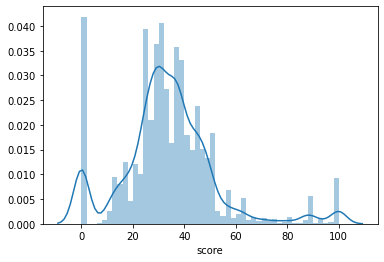

In [226]:
sns.distplot(biomednlp_eval_data.score)

<AxesSubplot:xlabel='score'>

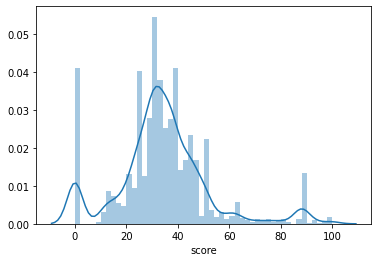

In [227]:
sns.distplot(distillroberta_eval_data.score)

<AxesSubplot:xlabel='score'>

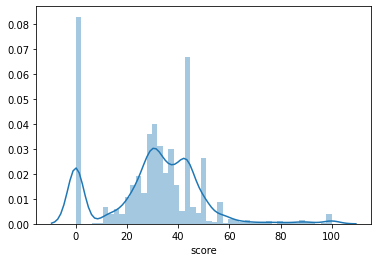

In [228]:
sns.distplot(bioclinical_eval_data.score)

In [229]:
bioclinical_eval_data.head(1)

,VAERS_ID,predicted_annotation,ground_truth_annotation,score
0,2547730,severe orthostatic,Blood pressure orthostatic abnormal,83


# Bioclinical Results

# at 20%, 40% and 60% Threshold

## Precision

In [62]:
def relevance(x, threshold):
    all_predictions = x.groupby(['predicted_annotation']).agg({'score': 'max'}).reset_index()
    found_predictions = len(all_predictions[all_predictions['score'] >= threshold])
    return found_predictions, len(all_predictions)

In [63]:
threshold_values = [20,40,60]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = bioclinical_eval_data.groupby(['VAERS_ID']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.VAERS_ID)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

In [64]:
all_relevant_predictions.head()

,VAERS_ID,found_labels,total_predictions,precision,threshold
0,2547730,5,6,0.833333,20
1,2547731,5,5,1.000000,20
2,2547732,9,9,1.000000,20
3,2547733,7,7,1.000000,20
4,2547734,6,7,0.857143,20


## Recall

In [65]:
def retrieval(x, threshold):
    all_labels = x.groupby(['ground_truth_annotation']).agg({'score': 'max'}).reset_index()
    found_labels = len(all_labels[all_labels['score'] >= threshold])
    total_predictions = x['predicted_annotation'].nunique()
    
    return found_labels, len(all_labels)

In [66]:
threshold_values = [20,40,60]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = bioclinical_eval_data.groupby(['VAERS_ID']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.VAERS_ID)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [67]:
all_retrieved_predictions.head(5)

,VAERS_ID,found_predictions,total_labels,recall,threshold
0,2547730,3,3,1.0,20
1,2547731,1,1,1.0,20
2,2547732,1,1,1.0,20
3,2547733,1,1,1.0,20
4,2547734,1,1,1.0,20


In [68]:
bioclinical_results = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['VAERS_ID','threshold'])
bioclinical_results = bioclinical_results[['VAERS_ID', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

bioclinical_results['f1_score'] = 2 * (bioclinical_results['recall'] * bioclinical_results['precision']) / (bioclinical_results['recall'] + bioclinical_results['precision'])
bioclinical_results

,VAERS_ID,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,2547730,20,3,6,5,3,1.000000,0.833333,0.909091
1,2547731,20,1,5,5,1,1.000000,1.000000,1.000000
2,2547732,20,1,9,9,1,1.000000,1.000000,1.000000
3,2547733,20,1,7,7,1,1.000000,1.000000,1.000000
4,2547734,20,1,7,6,1,1.000000,0.857143,0.923077
...,...,...,...,...,...,...,...,...,...
29995,2565380,60,1,6,0,0,0.000000,0.000000,NaN
29996,2565382,60,1,7,0,0,0.000000,0.000000,NaN
29997,2565482,60,3,8,1,1,0.333333,0.125000,0.181818
29998,2565486,60,2,7,0,0,0.000000,0.000000,NaN


In [69]:
bioclinical_results.to_csv("10ktest_bioclinical_results.csv")

# BiomedNLP Results

## Precision

In [70]:
threshold_values = [20,40,60]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = biomednlp_eval_data.groupby(['VAERS_ID']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.VAERS_ID)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

In [75]:
all_relevant_predictions.head()

,VAERS_ID,found_labels,total_predictions,precision,threshold
0,2547730,5,6,0.833333,20
1,2547731,5,5,1.000000,20
2,2547732,8,8,1.000000,20
3,2547733,5,5,1.000000,20
4,2547734,5,6,0.833333,20


## Recall

In [71]:
threshold_values = [20,40,60]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = biomednlp_eval_data.groupby(['VAERS_ID']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.VAERS_ID)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [74]:
all_retrieved_predictions.head()

,VAERS_ID,found_predictions,total_labels,recall,threshold
0,2547730,3,3,1.0,20
1,2547731,1,1,1.0,20
2,2547732,1,1,1.0,20
3,2547733,1,1,1.0,20
4,2547734,1,1,1.0,20


In [76]:
biomedNLP_results = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['VAERS_ID','threshold'])
biomedNLP_results = biomedNLP_results[['VAERS_ID', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

biomedNLP_results['f1_score'] = 2 * (biomedNLP_results['recall'] * biomedNLP_results['precision']) / (biomedNLP_results['recall'] + biomedNLP_results['precision'])
biomedNLP_results

,VAERS_ID,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,2547730,20,3,6,5,3,1.000000,0.833333,0.909091
1,2547731,20,1,5,5,1,1.000000,1.000000,1.000000
2,2547732,20,1,8,8,1,1.000000,1.000000,1.000000
3,2547733,20,1,5,5,1,1.000000,1.000000,1.000000
4,2547734,20,1,6,5,1,1.000000,0.833333,0.909091
...,...,...,...,...,...,...,...,...,...
29995,2565380,60,1,9,0,0,0.000000,0.000000,NaN
29996,2565382,60,1,8,1,1,1.000000,0.125000,0.222222
29997,2565482,60,3,7,1,1,0.333333,0.142857,0.200000
29998,2565486,60,2,6,0,0,0.000000,0.000000,NaN


In [77]:
biomedNLP_results.to_csv("10ktest_biomedNLP_results.csv")

# DistilRoberta Model

## Precision 

In [78]:
threshold_values = [20,40,60]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = distillroberta_eval_data.groupby(['VAERS_ID']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.VAERS_ID)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

In [79]:
all_relevant_predictions.head()

,VAERS_ID,found_labels,total_predictions,precision,threshold
0,2547730,4,5,0.80,20
1,2547731,6,6,1.00,20
2,2547732,8,8,1.00,20
3,2547733,5,5,1.00,20
4,2547734,3,4,0.75,20


## Recall

In [80]:
threshold_values = [20,40,60]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = distillroberta_eval_data.groupby(['VAERS_ID']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.VAERS_ID)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [82]:
all_retrieved_predictions.head()

,VAERS_ID,found_predictions,total_labels,recall,threshold
0,2547730,3,3,1.0,20
1,2547731,1,1,1.0,20
2,2547732,1,1,1.0,20
3,2547733,1,1,1.0,20
4,2547734,1,1,1.0,20


In [81]:
distillroberta_results = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['VAERS_ID','threshold'])
distillroberta_results = distillroberta_results[['VAERS_ID', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

distillroberta_results['f1_score'] = 2 * (distillroberta_results['recall'] * distillroberta_results['precision']) / (distillroberta_results['recall'] + distillroberta_results['precision'])
distillroberta_results

,VAERS_ID,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,2547730,20,3,5,4,3,1.000000,0.80,0.888889
1,2547731,20,1,6,6,1,1.000000,1.00,1.000000
2,2547732,20,1,8,8,1,1.000000,1.00,1.000000
3,2547733,20,1,5,5,1,1.000000,1.00,1.000000
4,2547734,20,1,4,3,1,1.000000,0.75,0.857143
...,...,...,...,...,...,...,...,...,...
29995,2565380,60,1,9,0,0,0.000000,0.00,NaN
29996,2565382,60,1,7,0,0,0.000000,0.00,NaN
29997,2565482,60,3,8,2,1,0.333333,0.25,0.285714
29998,2565486,60,2,6,0,0,0.000000,0.00,NaN


In [31]:
distillroberta_results.to_csv("10ktest_distillroberta_results.csv")

In [ ]:
#distillroberta_results
#bioclinical_results
#biomedNLP_results

In [83]:
distillroberta_results.groupby("threshold")["recall","precision","f1_score"].mean()

/var/folders/_l/b6xwsf494bjcy6h68bqlx5jh0000gn/T/ipykernel_2520/2544766018.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  distillroberta_results.groupby("threshold")["recall","precision","f1_score"].mean()


,recall,precision,f1_score
threshold,,,
20,0.918040,0.846630,0.930465
40,0.762867,0.389994,0.611555
60,0.420935,0.129610,0.422180


In [84]:
bioclinical_results.groupby("threshold")["recall","precision","f1_score"].mean()

/var/folders/_l/b6xwsf494bjcy6h68bqlx5jh0000gn/T/ipykernel_2520/4144614413.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bioclinical_results.groupby("threshold")["recall","precision","f1_score"].mean()


,recall,precision,f1_score
threshold,,,
20,0.939454,0.787075,0.885197
40,0.818216,0.398105,0.599745
60,0.410209,0.154495,0.478353


In [85]:
biomedNLP_results.groupby("threshold")["recall","precision","f1_score"].mean()

/var/folders/_l/b6xwsf494bjcy6h68bqlx5jh0000gn/T/ipykernel_2520/3766425644.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biomedNLP_results.groupby("threshold")["recall","precision","f1_score"].mean()


,recall,precision,f1_score
threshold,,,
20,0.925880,0.838122,0.922419
40,0.797508,0.381702,0.588010
60,0.438954,0.112549,0.365057


In [58]:
distillroberta_results.f1_score.mean()

0.7077651995601568

In [59]:
bioclinical_results.f1_score.mean()

0.7077651995601568

In [34]:
biomedNLP_results.f1_score.mean()

0.9224192885697498

## ----- x -------- x -------- x ----